# Preprocessing normal vectors
This notebook has the purpose of showing the implementation of the normal vector generation per vertex.

In [21]:
from Pointcloud.Modules.GraphBuilder import GraphBuilder
from Pointcloud.Modules.Object import FilePointcloud, Pointcloud
from Pointcloud.Modules.Processor import Processor
# from Pointcloud.Modules.deprecated.Preprocessor import Preprocessor
from Pointcloud.Modules.Visualize import (
    visualize_coloring,
    plot_2d,
    plot_3d,
    plot_vectors,
    plot_plane,
    visTensorVoting,
    visNormalTensorVoting
)
from Pointcloud.Modules.Utils import (
    NumpyUtils,
    TorchUtils
)

# from deltaconv.geometry import estimate_basis
from meshplot import plot as mp_plot
import numpy as np
import torch_geometric as tg
import torch

# EXAMPLE_OBJ_FILE = "common-3d-test-models-master/stanford-bunny.obj"
# EXAMPLE_OBJ_FILE = "common-3d-test-models-master/fandisk.obj"
EXAMPLE_OBJ_FILE = "cube6146.obj"

In [46]:
pointcloud = Pointcloud.loadObj(EXAMPLE_OBJ_FILE)
pp = Processor(pointcloud)
pp.noise.generateNoise(0.3, TorchUtils.averageEdgeLength(pointcloud.v, edge_index = pp.graphBuilder.getKNNEdgeIndex(6)))

In [47]:
pos = pointcloud.v
edge_index = pp.graphBuilder.getKNNEdgeIndex(12)
normals = pp.graphBuilder.getPVTDecompositionWithKNN(edge_index)[..., 0]
pp.graph.n = normals
v = pos.numpy()
n = normals.numpy() / 20
plot = mp_plot(v, shading={"point_size": 0.05})
lines = plot.add_lines(v, v + n)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [48]:
graph = pp.graph
_edge_index = edge_index
graph.edge_index = torch.cat([_edge_index, _edge_index.flip(0)], dim=1).unique(dim=1, sorted=True)
normals = pp.graphBuilder.getPVTDecompositionWithKNN(pp.graphBuilder.getKNNEdgeIndex(12))[..., 0]
pp.graphBuilder.calculateEdgeCost()
mst_edge_index, mst_edge_attr = pp.graphBuilder.calculateUndirectedMST()
pp.graphBuilder.flipNormalsWithMST(mst_edge_index)

plot = mp_plot(graph.pos.numpy(), shading={"point_size": 0.002})
_ = plot.add_lines(graph.pos[mst_edge_index[0]], graph.pos[mst_edge_index[1]])

Creating MST..: 100%|██████████| 76270/76270 [00:01<00:00, 43350.31it/s]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.005268…

In [49]:
print(graph.is_undirected())
plot = mp_plot(graph.pos.numpy(), shading={"point_size": 0.1})
plot.add_lines(graph.pos.numpy(), (graph.pos + graph.n / 20).numpy())

True


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.005268…

1

In [43]:
# graph.edge_index = graph.edge_index[:, mst]
graph.edge_index, graph.edge_attr = tg.utils.to_undirected(graph.edge_index, graph.edge_attr, graph.num_nodes)
graph.edge_index.max()

tensor(6145)

In [44]:
idx = torch.tensor([torch.randint(0, graph.num_nodes, (1,))])
selection = Preprocessor(pointcloud).toPatchIndices(idx)
data, slices = NumpyUtils.packSequence(selection.neighbourhood, selection.mask)
patch0_idx = data[slices[0]:slices[1]]
patch_v = graph.pos[patch0_idx]# + (2*torch.rand((patch0_idx.shape[0], 3)) - 1) * 1
patch_n = graph.n[patch0_idx]
_, ax = visTensorVoting(patch_v, torch.ones((slices[1])))
plot_vectors(ax, patch_v, patch_n / 500, color="purple", arrow_length_ratio=0.05, linewidth=0.3)
# _, ax = visTensorVoting(patch_n, lambda x: torch.ones((x.size(0))))
# plot_vectors(ax, torch.zeros_like(patch_n), patch_n, color="blue", arrow_length_ratio=0.05, linewidth=0.3)

_ = visNormalTensorVoting(patch_v, patch_n, torch.ones(slices[1]))

NameError: name 'Preprocessor' is not defined

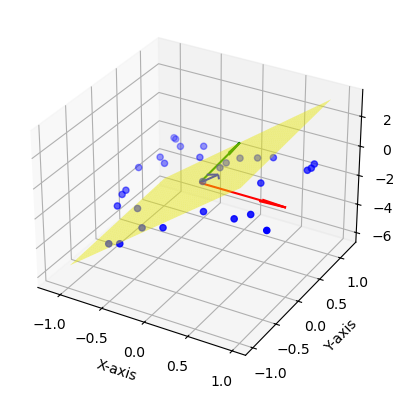

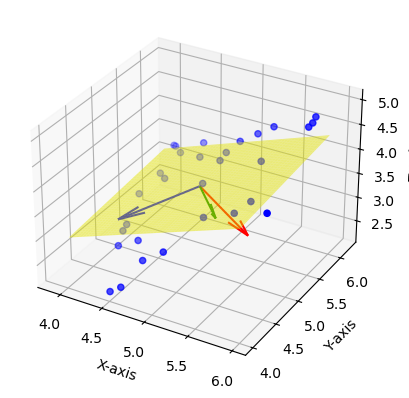

In [ ]:
N = 30
n = torch.nn.functional.normalize(2*torch.rand((3,)) - 1, p=2, dim=0)
normals = torch.nn.functional.normalize(2*torch.rand((N, 3)) - 1, p=2, dim=0)
c = 2*torch.rand(3,) - 1
v = 2*torch.rand((N, 3)) - 1
v[:, 2] = ((n*c).sum(dim=0) - n[0]*v[:, 0] - n[1]*v[:, 1]) / n[2] #+ torch.rand((N,))*0.4

# _ = visNormalTensorVoting(v, normals, torch.ones(N))
_ = visTensorVoting(v, torch.ones(N))


v += 5

_ = visTensorVoting(v, torch.ones(N))